<a href="https://colab.research.google.com/github/G544/galinanana_ml/blob/main/kaggle/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [168]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"galinanana","key":"8147c232cb591bab100fb9318cb5ce2d"}'}

In [169]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [170]:
! kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [171]:
from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib as plt 
import matplotlib.pyplot as plt
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

# Чтение данных


In [172]:
filezip = '/content/titanic.zip'

z = ZipFile(filezip)
print(z.infolist())
with ZipFile(filezip, 'r') as zip_file:
    zip_file.extract('train.csv', '.')
    zip_file.extract('test.csv', '.')
    zip_file.extract('gender_submission.csv', '.')

[<ZipInfo filename='gender_submission.csv' compress_type=deflate file_size=3258 compress_size=872>, <ZipInfo filename='test.csv' compress_type=deflate file_size=28629 compress_size=11171>, <ZipInfo filename='train.csv' compress_type=deflate file_size=61194 compress_size=22388>]


# First View

In [257]:
data = pd.read_csv('/content/train.csv')
data.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
463,464,0,2,"Milling, Mr. Jacob Christian",male,48.0,0,0,234360,13.0000,NaN,S
502,503,0,3,"O'Sullivan, Miss. Bridget Mary",female,NaN,0,0,330909,7.6292,NaN,Q
520,521,1,1,"Perreault, Miss. Anne",female,30.0,0,0,12749,93.5000,B73,S


Вещественные признаки : Age, Fare  
Категориальные : Sibsp, Cabin, Embarked, Sex, Parch, Pclass


In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [23]:
data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


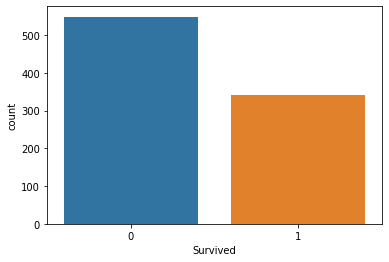

In [24]:
sns.countplot(x='Survived',data=data)
plt.show()

In [51]:
balance = {0:data['Survived'].value_counts()[0]/data.shape[0], 1:data['Survived'].value_counts()[1]/data.shape[0]}

Классы несбалансированы

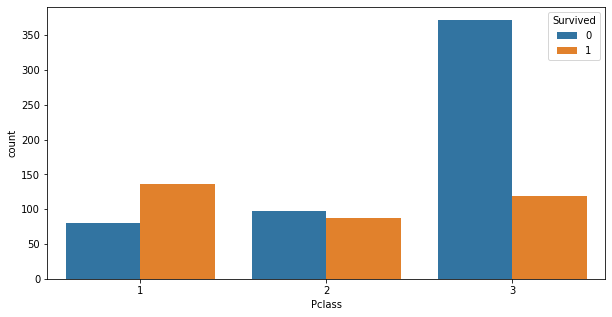

In [25]:
plt.figure(figsize=(10,5))
sns.countplot(x='Pclass', hue='Survived', data=data);

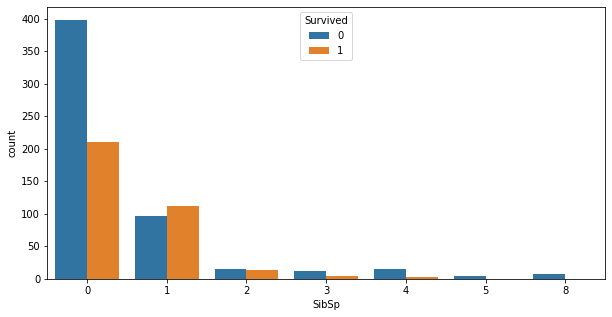

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(x='SibSp', hue='Survived', data=data);

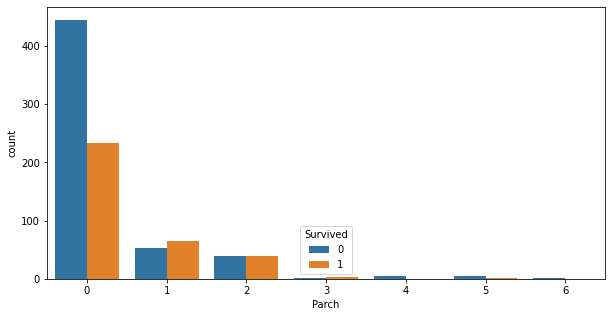

In [27]:
plt.figure(figsize=(10,5))
sns.countplot(x='Parch', hue='Survived', data=data)

# Features extraction


In [258]:
max_corr = abs(data.corr()['Age']).sort_values().index[-3:-1]
corr_df = data[~data['Age'].isna()][max_corr]
corr_target = data[~data['Age'].isna()]['Age']
lr_corr = LinearRegression()
lr_corr.fit(corr_df, corr_target)
def preproc(data):
  global lr_corr
  data['Cabin_ffil'] =( ~data['Cabin'].isna()).astype(int)
  data['Ticket_digit'] = [s[0].isdigit() for s in data['Ticket']]
  data['Ticket_digit'] = data['Ticket_digit'].astype(int)
  data['Embarked'].fillna('Nan', inplace=True)
 # data['Age'].fillna(24.0, inplace=True)
  data['Age'].fillna(data['Age'].mean(), inplace=True)
 # data['Age'] = data['Age'].fillna(dict(zip(data.loc[data['Age'].isna()].index, list(lr_corr.predict(data[data['Age'].isna()][max_corr])))))
  data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True, axis=1)
 # data['SibSp'] = data['SibSp'].astype(str)
  #data['Parch'] = data['SibSp'].astype(str)
  #data['Pclass'] = data['SibSp'].astype(str)
  df = pd.concat([data,pd.get_dummies(data[['Sex', 'Embarked']])], axis=1)
  #df = pd.concat([data,pd.get_dummies(data[['Sex', 'Embarked', 'Pclass', 'SibSp','Parch']])], axis=1)
  df.drop(['Sex', 'Embarked','Pclass', 'SibSp','Parch'], axis=1, inplace=True)
  if 'Embarked_Nan' in list(df.columns):
    df.drop('Embarked_Nan', axis=1, inplace=True)
  df.fillna(0, inplace=True)
  sc = StandardScaler()
  df = sc.fit_transform(df)
  df = pd.DataFrame(columns = sc.get_feature_names_out(),data = df)
  return df

In [259]:
target = data['Survived']
data.drop('Survived', axis=1, inplace = True)
df = preproc(data)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(df, target)
X_train, X_test, y_train,  y_test = train_test_split(X_resampled, y_resampled, test_size=0.3)
#X_train, X_test, y_train,  y_test = train_test_split(df, target, test_size=0.3)

In [260]:
logreg = LogisticRegression()
ridge = RidgeClassifier()
nb = GaussianNB()
rf = RandomForestClassifier()
logreg.fit(X_train, y_train)
ridge.fit(X_train, y_train)
nb.fit(X_train, y_train)
rf.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)
y_pred_rd = ridge.predict(X_test)
y_pred_nb = nb.predict(X_test)
y_pred_rf = rf.predict(X_test)

In [261]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
for y, name in zip((y_pred_lr, y_pred_rd, y_pred_nb, y_pred_rf), ('lr', 'ridge', 'nb','rf')):
  pred_ac = round(accuracy_score(y, y_test),3)
  pred_pr = round(precision_score(y, y_test),3)
  pred_recall = round(recall_score(y, y_test),3)
  pred_f = round(f1_score(y, y_test),3)
  pred_roc = round(roc_auc_score(y, y_test),3)
  print(f'Score for {name}  ')
  print('')
  print(f'Accuracy для {name} {pred_ac}  ')
  print(f'Precision для {name} {pred_pr}  ')
  print(f'Recall для {name} {pred_recall}  ')
  print('')

Score for lr  

Accuracy для lr 0.77  
Precision для lr 0.75  
Recall для lr 0.788  

Score for ridge  

Accuracy для ridge 0.755  
Precision для ridge 0.714  
Recall для ridge 0.784  

Score for nb  

Accuracy для nb 0.739  
Precision для nb 0.714  
Recall для nb 0.759  

Score for rf  

Accuracy для rf 0.845  
Precision для rf 0.863  
Recall для rf 0.838  



# Настройка модели


In [143]:
params_dict = {'penalty': ['l1', 'l2', 'elasticnet'], 'C':[0.00001,0.0001, 0.001,0.01,0.1,1,10,100,1000], 'tol': [1e-5, 1e-6]}
lr = LogisticRegression( solver='saga')
gv = GridSearchCV(lr, param_grid=params_dict, scoring = 'accuracy')
gv.fit(df, target)

GridSearchCV(estimator=LogisticRegression(solver='saga'),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'tol': [1e-05, 1e-06]},
             scoring='accuracy')

In [191]:
lr_best = LogisticRegression(solver='saga', **gv.best_params_)
lr_best.fit(X_train, y_train)
y_pred = lr_best.predict(X_test)
print(accuracy_score(y_test, y_pred))
#lr_best.fit(df,target)

0.7333333333333333


In [181]:
BC_param_grid = {
'bootstrap': [True, False],
'bootstrap_features': [True, False],    
'n_estimators': [5, 10, 15],
'max_samples' : [0.6, 0.8, 1.0],
'base_estimator__penalty': ['l1', 'l2', 'elasticnet'],
'base_estimator__C':[0.001,0.01,0.1,1,10,100,1000]
}
bag_cl = BaggingClassifier(lr)
gv_bag = GridSearchCV(bag_cl, param_grid=BC_param_grid, scoring = 'accuracy')
gv_bag.fit(df, target)
#y_pred = bag_cl.predict(X_test)
#print(accuracy_score(y_test, y_pred))

GridSearchCV(estimator=BaggingClassifier(base_estimator=LogisticRegression(solver='saga')),
             param_grid={'base_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                               1000],
                         'base_estimator__penalty': ['l1', 'l2', 'elasticnet'],
                         'bootstrap': [True, False],
                         'bootstrap_features': [True, False],
                         'max_samples': [0.6, 0.8, 1.0],
                         'n_estimators': [5, 10, 15]},
             scoring='accuracy')

In [235]:
scores_threshold = []
for i in np.arange(0,1,0.001):
  y_pred = (lr_best.predict_proba(X_test)[:,1]>i).astype(int)
  scores_threshold.append(accuracy_score(y_test, y_pred))

max(scores_threshold)

0.7454545454545455

Tuning Лог регрессии особенно ничего не дал

In [239]:
params_dict = {'criterion': ['entropy', 'gini', 'log_loss'], 'n_estimators':[50, 100, 500], 'max_depth':[4,8,'None'], 'min_samples_split':[1,2,3, 6]}
rf = RandomForestClassifier(class_weight = balance)
gv = GridSearchCV(rf, param_grid=params_dict, scoring = 'accuracy')
gv.fit(df, target)

GridSearchCV(estimator=RandomForestClassifier(class_weight={0: 0.6161616161616161,
                                                            1: 0.3838383838383838}),
             param_grid={'criterion': ['entropy', 'gini', 'log_loss'],
                         'max_depth': [4, 8, 'None'],
                         'min_samples_split': [1, 2, 3, 6],
                         'n_estimators': [50, 100, 500]},
             scoring='accuracy')

In [246]:
gv.best_estimator_

RandomForestClassifier(class_weight={0: 0.6161616161616161,
                                     1: 0.3838383838383838},
                       max_depth=8, n_estimators=500)

In [262]:
rf = RandomForestClassifier(class_weight={0: 0.6161616161616161,
                                     1: 0.3838383838383838},
                       max_depth=8, n_estimators=500)
rf.fit(df, target)

RandomForestClassifier(class_weight={0: 0.6161616161616161,
                                     1: 0.3838383838383838},
                       max_depth=8, n_estimators=500)

# Submission

In [263]:
test = pd.read_csv('/content/test.csv')
id = test['PassengerId']
X_submiss = preproc(test)
diff = list(set(X_train.columns).difference(set(X_submiss.columns)))
dict_idx = ()
for itm in diff:
  idx = list(X_train.columns).index(itm)
  X_submiss.insert(idx, itm, 0)
submission_lr = logreg.predict(X_submiss)
submission_rd = ridge.predict(X_submiss)
submission_nb = nb.predict(X_submiss)
submission_rf = rf.predict(X_submiss)

In [264]:
d = {'PassengerId':id, 'Survived':submission_lr}
log_reg_df = pd.DataFrame(d)
d = {'PassengerId':id, 'Survived':submission_rd}
ridge_df = pd.DataFrame(d)
d = {'PassengerId':id, 'Survived':submission_nb}
nb_df = pd.DataFrame(d)
d = {'PassengerId':id, 'Survived':submission_rf}
rf_df = pd.DataFrame(d)

In [254]:
log_reg_df.to_csv('lr1_submiss.csv', index=False)
ridge_df.to_csv('rd_submiss.csv', index=False)
nb_df.to_csv('nb_submiss.csv', index=False)
rf_df.to_csv('rf_submiss.csv', index=False)

In [162]:
!kaggle competitions submit -c titanic -f lr1_submiss.csv -m Feats_only_with_embarked_witoutnan_agecorr_oversampling_tuned_model_with_bagging

100% 2.77k/2.77k [00:03<00:00, 824B/s]
Successfully submitted to Titanic - Machine Learning from Disaster

In [ ]:
#!kaggle competitions submit -c titanic -f rd_submiss.csv -m Message

In [82]:
!kaggle competitions submit -c titanic -f nb_submiss.csv -m Balance_cat_feat

100% 2.77k/2.77k [00:01<00:00, 1.88kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

In [265]:
!kaggle competitions submit -c titanic -f rf_submiss.csv -m Tuned_age_mean

100% 2.77k/2.77k [00:02<00:00, 1.37kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster